In [1]:
import os
import numpy as np

# ModuleNotFoundError: for napari and ipywidgets. to fix this, try...
# why is ipywidgets accessible from ipykernel kernel, but not cellpose kernel? I don't understand.
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget
import importlib # use importlib.reload(module_name) when updating a module's code


from matplotlib import pyplot as plt
from cellpose import plot, utils, io
from cellpose import models
from cellpose.io import imread
#from cellpose import custom #custom functions

#!conda list numpy
#!conda list numba
#!conda list scipy
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#numpy                     1.20.0                   pypi_0    pypi
#numpydoc                  1.4.0                    pypi_0    pypi
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#numba                     0.56.0                   pypi_0    pypi
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#scipy                     1.7.3            py38h0a974cb_0  



In [2]:

# locate and access input image files
outputFolder = "testResults/"
filename = "WT_data_sample_movie_3-1_single_timepoint.tif"
X_total = io.imread(filename)

print(np.shape(X_total))
print(np.shape(np.transpose(X_total,(0,2,3,1))))

start = 0
numPlanes = 335
X_total = np.transpose(X_total,(0,2,3,1))
numYPlanes = np.shape(X_total)[2]
X_total[:,:,:,[0,1]] = X_total[:,:,:,[1,0]] # swap 1,0 in 4th dimension to get nuclear channel in dimension 0, membrane in 1
X_total = X_total[start:start+numPlanes,:,:,:]
print(np.shape(X_total))

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [00:00<00:00, 1056.79it/s]


(335, 2, 601, 961)
(335, 601, 961, 2)
(335, 601, 961, 2)


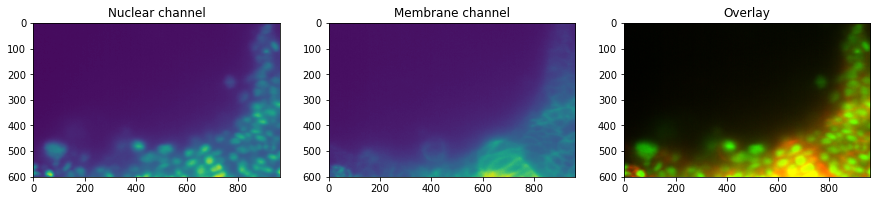

In [3]:
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_total[idx, ..., 0])
ax[1].imshow(X_total[idx, ..., 1])
ax[2].imshow(plot.image_to_rgb(X_total[idx,:,:,:], channels = [2,1]))

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [12]:
import extCellposeTest
import importlib
importlib.reload(extCellposeTest)
# make a prediction using cellpose, then compare overlay with the prediction on top
# maybe use show_segmentation function
#model = models.Cellpose(gpu=True, model_type='cyto')
#model = models.Cellpose(gpu=True, model_type='cyto2') #makes more default segmentations, but lines are not as crisp as cyto

model = extCellposeTest.Cellpose(gpu=True, model_type='cyto2') # model = Cellpose object = a class inside models.py or extCellposeTest.py
# extCellposeTest (see extCellposeTest.py) overrides and adds some functionality to default API

#model_new = models.CellposeModel(gpu=True, model_type='tissuenet') #doesn't get the membranes very well even with higher flow.
# tissuenet really feels more like a nuclear segmentator

In [13]:
importlib.reload(extCellposeTest)

chan = [2,1]
diam=47 # open image in FIJI, draw line segment on a median sized cell, analyze > measure to get pixel count
img = X_total
#masks, flows, styles, _ = model.eval(img, diameter=diam, flow_threshold = 0.6, do_3D=False, \
#                                             z_axis = 0, stitch_threshold=0.8, channels=chan)

masks, flows, styles, _ = model.eval_test(img, diameter=diam, flow_threshold = 0.6, do_3D=False, \
                                             z_axis = 0, stitch_threshold=0.8, channels=chan)

# takes 4m15s to run on lab computer, single timepoint, 335x601x961
#masks, flows, styles, _ = model.eval(img, diameter=diam, do_3D=True, \
#                                             z_axis = 0, channels=chan)
## This runs the code with the 2D algorithm, stitching slices 
#   as described here https://cellpose.readthedocs.io/en/latest/inputs.html 

np.save(outputFolder+'output_masks.npy', masks)
np.save(outputFolder+'output_outlines.npy',utils.masks_to_outlines(masks))

AttributeError: 'CellposeModel' object has no attribute 'eval_test'

In [ ]:
print(np.shape(img))
showPlots = True
if (showPlots):
    # plot in XY 
    zskip = 10
    yskip = 50

    # decide how to arrange subplots
    totalNumberOfPlots = int(2* numPlanes / zskip) + 1 
    numberOfColumns = int(totalNumberOfPlots/2)
    numberOfRows = int(totalNumberOfPlots/numberOfColumns)
    print(totalNumberOfPlots, numberOfColumns, numberOfRows)


    # set image slice to rgb, overlay the mask as an outline onto original image and display in subplot
    plt.figure(figsize=(4,4), tight_layout=True)
    for i,iplane in enumerate(np.arange(0,numPlanes,zskip,int)):
        print(i, iplane)
        img0 = plot.image_to_rgb(img[iplane, :, :, 1].copy(), channels=[2])
        #plt.subplot(numberOfRows,numberOfColumns,i+1)
        outlines = utils.masks_to_outlines(masks[iplane])
        outX, outY = np.nonzero(outlines)
        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,75,75])
        plt.imshow(imgout)
        plt.title('iplane = %d'%iplane)
        #plt.subplot(numberOfRows,numberOfColumns, (i+numberOfColumns+1)) 
        #plt.imshow(masks[iplane])
        plt.savefig(outputFolder+"test3D_XY" + str(i) + ".jpg", dpi=200)


    # plot in XZ: this is REALLY important to check cells are being assigned correctly 

    # decide how to arrange subplots
    totalNumberOfPlots = int(2* numYPlanes / yskip) + 1
    numberOfColumns = int(totalNumberOfPlots/2)
    numberOfRows = int(totalNumberOfPlots/numberOfColumns)
    print(totalNumberOfPlots, numberOfColumns, numberOfRows)

    # set image slice to rgb, overlay the mask as an outline onto original image and display in subplot
    plt.figure(figsize=(4,4), tight_layout=True)
    for i,iplane in enumerate(np.arange(0,numYPlanes,yskip,int)):
        print(i, iplane)
        img0 = plot.image_to_rgb(img[:, :, iplane, 1].copy(), channels=[2])
        #plt.subplot(numberOfRows,numberOfColumns,i+1)
        outlines = utils.masks_to_outlines(masks[:, :, iplane])
        #print(np.shape(masks), np.shape(masks[:, :, iplane]))
        outX, outY = np.nonzero(outlines)
        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,75,75])
        plt.imshow(imgout)
        plt.title('iplane = %d'%iplane)
        #plt.subplot(numberOfRows,numberOfColumns, (i+numberOfColumns+1)) 
        #plt.imshow(masks[:, :, iplane])
        plt.savefig(outputFolder+"test3D_XZ" + str(i) + ".jpg", dpi=200)


In [ ]:
!jupyter --version
!python --version
import napari
img_4D = io.imread("WT_data_sample_movie_3-1_single_timepoint.tif")[:,0,:,:]
masks = np.load(outputFolder + "output_masks.npy") # you may need imread if these are tiffs 
outlines = np.load(outputFolder + "output_outlines.npy") # you may need imread if these are tiffs 

viewer = napari.Viewer() 
viewer.add_image(img_4D) 
viewer.add_labels(masks) 
viewer.add_labels(outlines)

In [ ]:
print(np.shape(img_4D))
print(np.shape(masks))

In [ ]:
A = np.zeros((5,5))
print(A)
print(not A.size)
print(A.size)

In [8]:
import inheritanceOriginal
import inheritanceNew
import importlib
importlib.reload(inheritanceOriginal)
importlib.reload(inheritanceNew)

A = inheritanceOriginal.test()
A.display()
B = inheritanceNew.test()
B.display()
B.newFunction()

1
2
3
